In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso ,Ridge,RidgeCV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import optuna
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')

In [3]:
RETUNE_CATBOOST = False
RETUNE_LGBM = False
RETUNE_LASSO = False

In [4]:
competition = pd.read_csv('./datasets/train.csv').drop(columns='id')
original = pd.read_csv('./datasets/credit_risk_dataset.csv')
test = pd.read_csv('./datasets/test.csv').drop(columns='id')

df_combined=pd.concat([competition, original])
df_combined=df_combined.drop_duplicates()

In [5]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91061 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91061 non-null  int64  
 1   person_income               91061 non-null  int64  
 2   person_home_ownership       91061 non-null  object 
 3   person_emp_length           90174 non-null  float64
 4   loan_intent                 91061 non-null  object 
 5   loan_grade                  91061 non-null  object 
 6   loan_amnt                   91061 non-null  int64  
 7   loan_int_rate               87966 non-null  float64
 8   loan_percent_income         91061 non-null  float64
 9   cb_person_default_on_file   91061 non-null  object 
 10  cb_person_cred_hist_length  91061 non-null  int64  
 11  loan_status                 91061 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 9.0+ MB


# EDA

In [6]:
def create_bivariate_plots_numerical(df, target_column):
    
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if target_column in numerical_cols:
        numerical_cols.remove(target_column)
    
    # setting up the matplotlib figure
    n_rows = len(numerical_cols)  # One row for each numerical column
    fig, axes = plt.subplots(n_rows, 2, figsize=(10, n_rows * 4))
    
    # flatten the axes array for easy iteration
    #axes = axes.flatten()
    
    # creating bivariate plots
    for i, col in enumerate(numerical_cols):
        # Create a histogram
        sns.histplot(data=df, x=col, hue=target_column, ax=axes[i, 0], kde=True)
        axes[i, 0].set_title(f'{col}')
        
        # Create a boxplot beside the histogram
        sns.boxplot(data=df, y=col, x=target_column, ax=axes[i, 1])
        axes[i, 1].set_title(f'{col}')
    
    plt.tight_layout()
    plt.show()

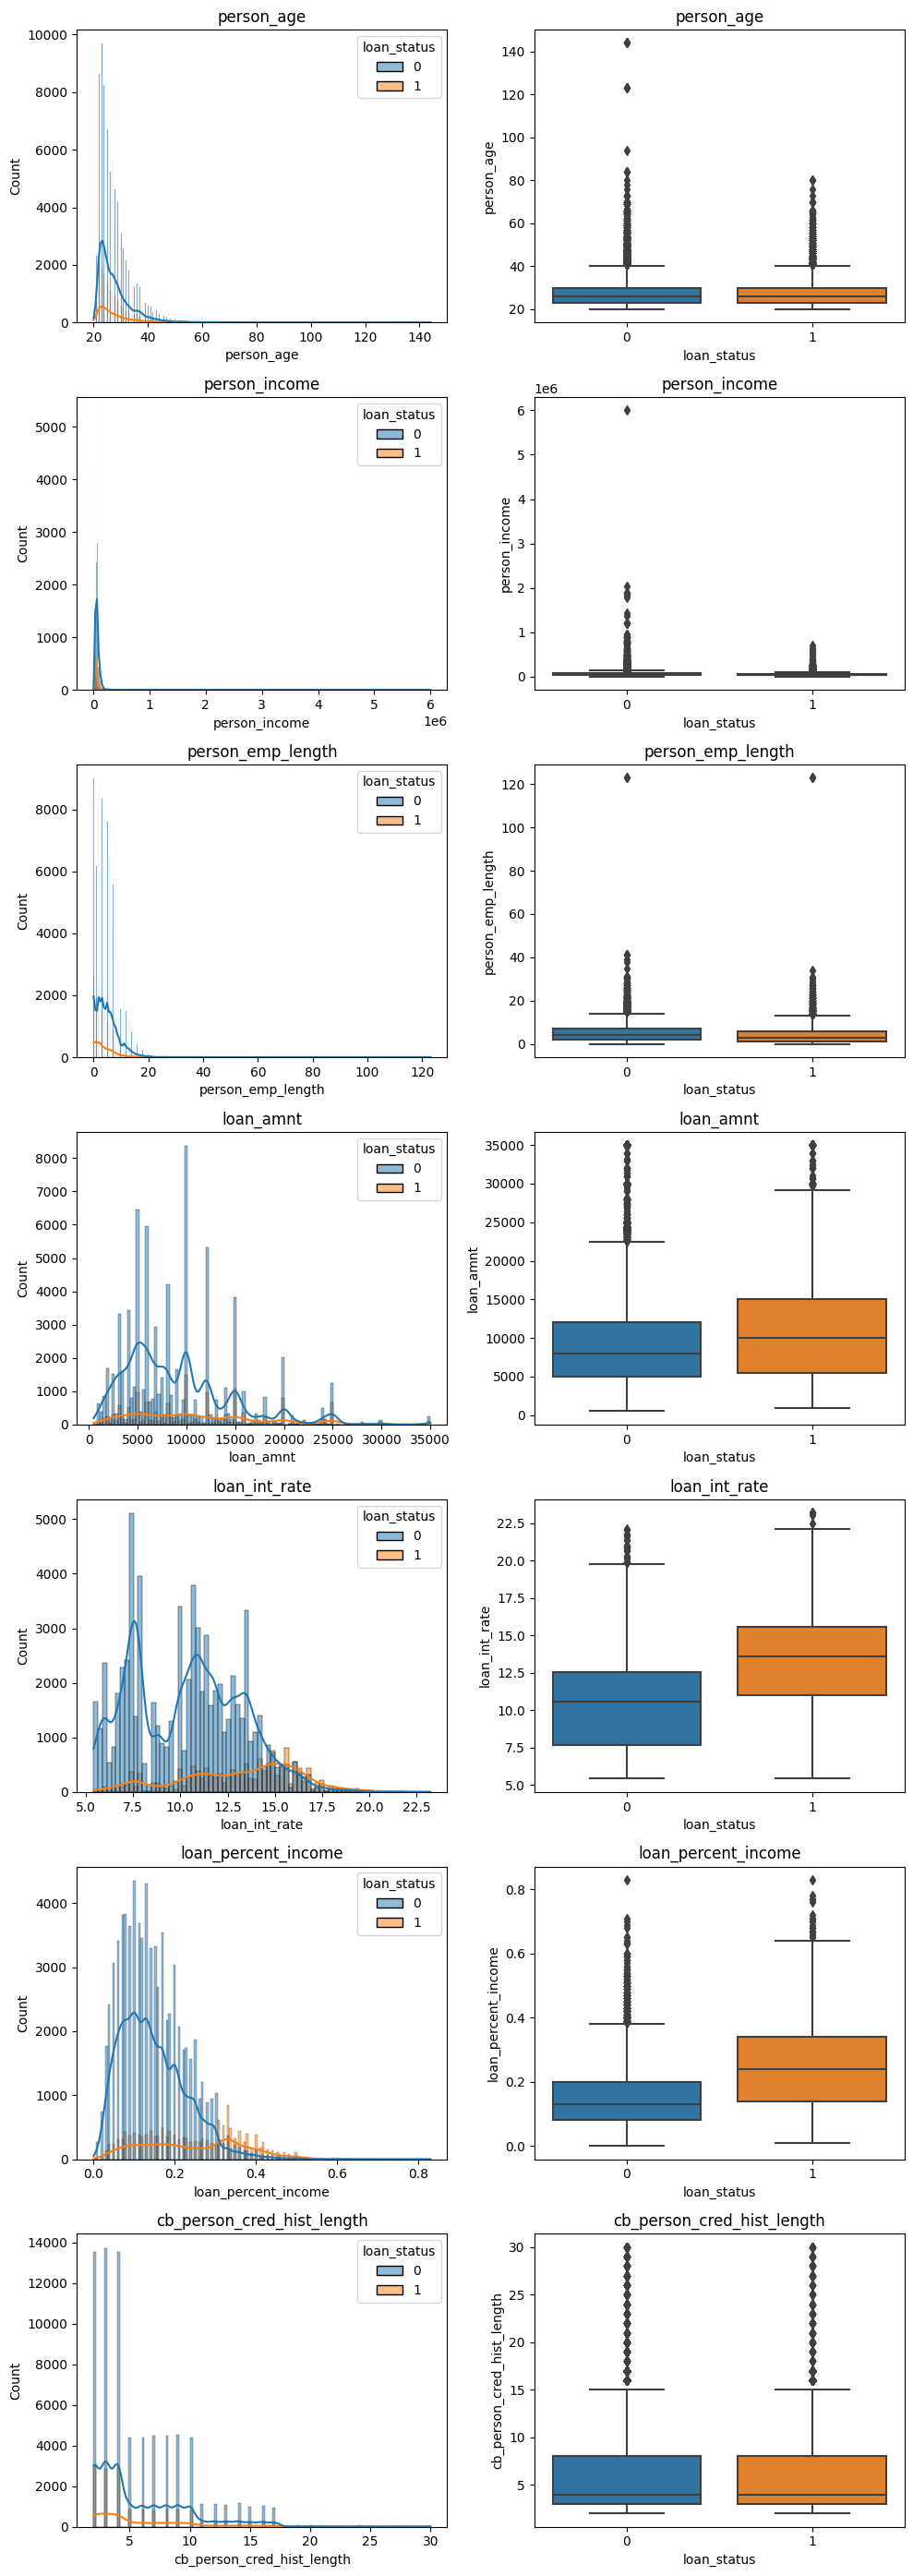

In [7]:
create_bivariate_plots_numerical(df_combined.reset_index(drop=True), 'loan_status')

In [8]:
def create_bivariate_plots_categorical(df, target_column):
    
    # selecting categorical column names
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if target_column in categorical_cols:
        categorical_cols.remove(target_column)

    # setting up the matplotlib figure
    n_rows = int(np.ceil(len(categorical_cols)/2))  # One row for each numerical column
    fig, axes = plt.subplots(n_rows, 2, figsize=(10, n_rows * 4))
    
    # flatten the axes array for easy iteration
    axes = axes.flatten()
    
    for i, col in enumerate(categorical_cols):
        # calculating the percentage of positive target variable for each category
        percentage_df = df.groupby(col)[target_column].mean().sort_values().reset_index()
        percentage_df[target_column] = percentage_df[target_column] * 100  # convert to percentage

        # creating bar plots
        sns.barplot(data=percentage_df, x=col, y=target_column, ax = axes[i], palette='viridis')
        axes[i].set_title(f'Percentage of Loan Default by {col}')
        axes[i].set_xticks(axes[i].get_xticks(), axes[i].get_xticklabels(), rotation=45, ha='right')
        axes[i].set_ylabel(f'Loan Default %')
        
    plt.tight_layout()
    plt.show()

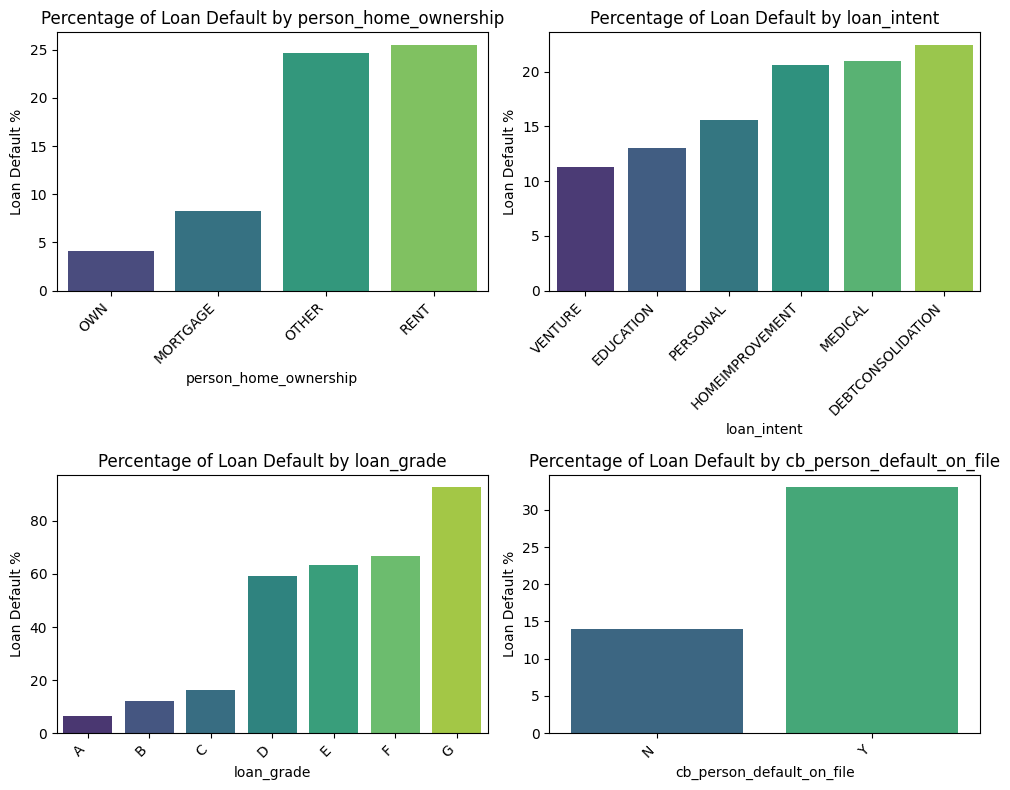

In [9]:
create_bivariate_plots_categorical(df_combined.reset_index(drop=True), 'loan_status')

# PREPROCESSING

Missing Values

Clearly, the employment length of a person depends upon the age of the person. Therefore, we will calculate the median of the ratio of employment length to age, and then impute the missing employment lengths using this ratio and the person's age.

In [10]:
## median ratio
median_emp_age_ratio = (df_combined.person_emp_length/df_combined.person_age).median()

## imputing emp length using the calculated median and the given age
df_combined["person_emp_length"]=df_combined["person_emp_length"].fillna(median_emp_age_ratio*df_combined.person_age)

The loan interest rate is dependent upon the loan grade and whether the person has a loan default on file. Therefore, we will impute the missing interest rates using the median interest rates when grouped by loan grade and default on file status

In [11]:
df_combined["loan_int_rate"] = df_combined.groupby(["loan_grade","cb_person_default_on_file"])["loan_int_rate"].transform(
    lambda x: x.fillna(np.round(x.median(),2)))

Outliers

There are cases with:

Age > 100, and
Employment length > Age
However, such cases are very few. Therefore, we will simply remove such cases from the dataset

In [12]:
df_combined = df_combined[df_combined.person_age > df_combined.person_emp_length]
df_combined = df_combined[df_combined.person_age < 100]

# FEATURE ENGINEERING

In [13]:
def add_features(df):
    df2=df.copy()
    
    df2['income_bin'] = pd.qcut(df2['person_income'], 5, labels=False)
    df2['rate_bin'] = pd.qcut(df2['loan_int_rate'], 5, labels=False)
    df2["person_emp_length"] = df2["person_emp_length"].astype("int")
    df2['loan_grade'] = df2['loan_grade'].replace({'F': 'E', 'G': 'E'})
    
    df2['loan_to_income'] =  np.round(df2['loan_amnt']/df2['person_income'], 2)
    df2['total_amount_payable'] = np.floor(df2['loan_amnt'] * (1+df2['loan_int_rate']/100))
    df2['interest'] = np.floor(df2['loan_amnt'] * df2['loan_int_rate']/100)
    df2["amt_payable_to_income"] = np.round(df2['total_amount_payable']/df2['person_income'], 2)
    
    df2["loan_percent_error"] = np.round(df2['loan_to_income'] - df2["loan_percent_income"], 2)
    df2["income_2"] = np.floor(df2['loan_amnt']/df2["loan_percent_income"])
    df2["amt_payable_to_income_2"] = np.round(df2['total_amount_payable']/df2['income_2'], 2)
    
    df2['credit_hist_vs_age'] = np.round(df2['cb_person_cred_hist_length'] / df2['person_age'], 2)
    df2['credit_hist_vs_work'] = np.round(df2['person_emp_length']/df2['cb_person_cred_hist_length'], 2)
    df2['income_vs_age'] = np.round(df2['person_income'] / df2['person_age'], 2)
    df2['work_vs_age'] = np.round(df2['person_emp_length']/df2['person_age'], 2)

    df2['risk_flag'] = np.where((df2['cb_person_default_on_file'] == 'Y') & (df2['loan_grade'].isin(['D', 'E'])), 1, 0)
    df2['ratio1'] = np.round((df2['total_amount_payable']/df2['person_income'])*(df2['person_emp_length']/df2['person_age']), 2)
    df2['ratio2'] = np.floor(df2['person_emp_length']/df2['person_age']*df2['person_income'])

    df2["grade_home_interaction"] = df2['person_home_ownership'].astype(str) + '_' + df2['loan_grade'].astype(str)
    df2["grade_intent_interaction"] = df2['loan_intent'].astype(str) + '_' + df2['loan_grade'].astype(str)
    df2["home_intent_interaction"] = df2['person_home_ownership'].astype(str) + '_' + df2['loan_intent'].astype(str)

    return df2

In [14]:
df_combined_processed = add_features(df_combined)
df_test_processed = add_features(test)

# CATBOOST

In [15]:
preds_train, preds_test = pd.DataFrame(), pd.DataFrame()

In [16]:
X_train = df_combined_processed.drop(columns=["loan_status"])
y_train = df_combined_processed.loan_status

5.1 Encoding Categorical Columns for CatBoost¶


In [17]:
X_train=X_train.astype("string").astype("category")
df_test_catboost=df_test_processed.astype("string").astype("category")

cat_cols=X_train.columns[X_train.dtypes=='category'].tolist()

5.2 Catboost Hyperparameter Tuning with Optuna¶


In [18]:
def catboost_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 5000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 5),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 0, 2),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 5),
        'auto_class_weights' : trial.suggest_categorical('auto_class_weights', ['Balanced', None]),
        
    }


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # creating LightGBM classifier with suggested hyperparameters
        model = CatBoostClassifier(**params,
                                   random_seed=42,
                                   loss_function='Logloss',
                                   cat_features=cat_cols,
                                   thread_count=-1,
                                   eval_metric = 'AUC'
                                  )
        model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=150, verbose=False)
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)
    
    print(f'Trial {trial.number}: {auc_scores} , mean : {np.mean(auc_scores)}')
    return np.mean(auc_scores)

In [19]:
## I have already optimized the hyperparameters. To run the tuning again, set RETUNE_HYPERPARAMETERS to True.

if RETUNE_CATBOOST:
    catboost_study = optuna.create_study(direction='maximize', sampler=TPESampler(n_startup_trials=25, seed=42, multivariate=True))
    catboost_study.optimize(catboost_objective, n_trials=100)
    
    catboost_combined_data_best_params = catboost_study.best_params
    
else:
    ## optimal hyperparameters
    catboost_combined_data_best_params={
        'iterations': 2303,
        'learning_rate': 0.03521569512158623,
        'depth': 5,
        'l2_leaf_reg': 0.32046459329692467,
        'border_count': 65,
        'random_strength': 0.790092643536121,
        'bagging_temperature': 0.10007673146582075,
        'auto_class_weights': 'Balanced'
    }

In [20]:
## using stratified K-Fold Cross Validation because the dataset is imbalanced.

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
oof_preds = np.zeros(len(y_train))
test_preds = np.zeros(len(test))

catboost_model_final = CatBoostClassifier(**catboost_combined_data_best_params,
                                          random_seed=42,
                                          loss_function='Logloss',
                                          cat_features=cat_cols,
                                          task_type='GPU',
                                          metric_period=1,
                                          eval_metric = 'AUC',
                                          verbose=False
                                         )

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    catboost_model_final.fit(X_train_fold, y_train_fold, eval_set=(X_test_fold, y_test_fold), early_stopping_rounds=150)
    y_pred_proba = catboost_model_final.predict_proba(X_test_fold)[:, 1]
    auc_scores.append(roc_auc_score(y_test_fold, y_pred_proba))
    
    oof_preds[test_index] = catboost_model_final.predict_proba(X_test_fold)[:, 1]
    test_preds += catboost_model_final.predict_proba(df_test_catboost)[:, 1]/skf.get_n_splits()
    
preds_train['catboost_combined_data'] = oof_preds
preds_test['catboost_combined_data'] = test_preds

print(f'scores: {auc_scores} , mean : {np.mean(auc_scores)}')

scores: [0.9699091371307952, 0.9696795530510091, 0.9674491864047711, 0.9664263245468789, 0.9683306345008783] , mean : 0.9683589671268665


# LightGBM

In [21]:
X_train = df_combined_processed.drop(columns=["loan_status"])
y_train = df_combined_processed.loan_status

 Encoding Categorical Columns for LGBM

In [22]:
one_hot_columns = ['cb_person_default_on_file', 'loan_intent', 'person_home_ownership', 'grade_home_interaction', 'grade_intent_interaction', 'home_intent_interaction']
ordinal_columns = ['loan_grade']

ct = ColumnTransformer([
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'), one_hot_columns),
        ('ordinal', OrdinalEncoder(), ordinal_columns),
     ],
    remainder='passthrough'
)

In [23]:
X_train = ct.fit_transform(X_train).toarray()
X_train = pd.DataFrame(X_train, columns = ct.get_feature_names_out())
X_train.head()

onehot__cb_person_default_on_file_Y  onehot__loan_intent_EDUCATION  \
0                                  0.0                            1.0   
1                                  0.0                            0.0   
2                                  0.0                            0.0   
3                                  0.0                            0.0   
4                                  0.0                            0.0   

   onehot__loan_intent_HOMEIMPROVEMENT  onehot__loan_intent_MEDICAL  \
0                                  0.0                          0.0   
1                                  0.0                          1.0   
2                                  0.0                          0.0   
3                                  0.0                          0.0   
4                                  0.0                          1.0   

   onehot__loan_intent_PERSONAL  onehot__loan_intent_VENTURE  \
0                           0.0                          0.0   
1                           0.0                          0.0   
2                           1.0                          0.0   
3                           0.0                          1.0   
4                           0.0                          0.0   

   onehot__person_home_ownership_OTHER  onehot__person_home_ownership_OWN  \
0                                  0.0                                0.0   
1                                  0.0                                1.0   
2                                  0.0                                1.0   
3                                  0.0                                0.0   
4                                  0.0                                0.0   

   onehot__person_home_ownership_RENT  \
0                                 1.0   
1                                 0.0   
2                                 0.0   
3                                 1.0   
4                                 1.0   

   onehot__grade_home_interaction_MORTGAGE_B  ...  \
0                                        0.0  ...   
1                                        0.0  ...   
2                                        0.0  ...   
3                                        0.0  ...   
4                                        0.0  ...   

   remainder__loan_percent_error  remainder__income_2  \
0                            0.0              35294.0   
1                            0.0              57142.0   
2                            0.0              28571.0   
3                            0.0              70588.0   
4                            0.0              60000.0   

   remainder__amt_payable_to_income_2  remainder__credit_hist_vs_age  \
0                                0.19                           0.38   
1                                0.08                           0.09   
2                                0.23                           0.34   
3                                0.19                           0.17   
4                                0.11                           0.14   

   remainder__credit_hist_vs_work  remainder__income_vs_age  \
0                            0.00                    945.95   
1                            3.00                   2545.45   
2                            0.80                    993.10   
3                            2.80                   2333.33   
4                            0.67                   2727.27   

   remainder__work_vs_age  remainder__risk_flag  remainder__ratio1  \
0                    0.00                   0.0               0.00   
1                    0.27                   0.0               0.02   
2                    0.28                   0.0               0.06   
3                    0.47                   0.0               0.09   
4                    0.09                   0.0               0.01   

   remainder__ratio2  
0                0.0  
1            15272.0  
2             7944.0  
3            32666.0  
4             5454.0  

[5 rows 

In [24]:
df_test_processed = ct.transform(df_test_processed)

6.2 LGBM Hyperparameter Tuning with Optuna

In [25]:
def lgbm_objective(trial):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'bagging_freq' : trial.suggest_int('bagging_freq', 1, 3),
        'is_unbalance' : trial.suggest_categorical('is_unbalance', ["+", "-"]),
    }

    # creating LightGBM classifier with suggested hyperparameters
    lgbm_model = LGBMClassifier(**params, 
                                objective = 'binary',
                                random_state=42, 
                                n_jobs=-1, 
                                verbosity = -1, 
                                metric = 'binary_logloss', 
                                early_stopping_round=50)

    # stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        lgbm_model.fit(X_train_fold, y_train_fold, eval_set = [(X_test_fold, y_test_fold)], eval_metric = 'binary_logloss')
        y_pred_proba = lgbm_model.predict_proba(X_test_fold)[:, 1]
        auc_scores.append(roc_auc_score(y_test_fold, y_pred_proba))

    print(f'Trial {trial.number}: {auc_scores} , mean : {np.mean(auc_scores)}')
    return np.mean(auc_scores)

In [26]:
if RETUNE_LGBM:
    lgbm_study = optuna.create_study(direction='maximize', sampler=TPESampler(n_startup_trials=30, seed=42, multivariate=True))
    lgbm_study.optimize(lgbm_objective, n_trials=100)
    
    print('Best Hyperparameters:', lgbm_study.best_params)
    print('Best AUC:', lgbm_study.best_value)
    lgbm_combined_data_best_params = lgbm_study.best_params
else:
    lgbm_combined_data_best_params = {
        'n_estimators': 4375, 
        'learning_rate': 0.013652512047783658, 
        'num_leaves': 228, 
        'max_depth': 8, 
        'min_child_samples': 22, 
        'subsample': 0.9924119756979213, 
        'colsample_bytree': 0.6017422856889346, 
        'reg_alpha': 1.322109337182143, 
        'reg_lambda': 1.0212913941403268, 
        'bagging_freq': 3, 
        'is_unbalance': '-'
    }

In [27]:
## using stratified K-Fold Cross Validation because the dataset is imbalanced.

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
oof_preds = np.zeros(len(y_train))
test_preds = np.zeros(len(test))

lgbm_model_final = LGBMClassifier(**lgbm_combined_data_best_params, 
                                  random_state=42, 
                                  #n_jobs=-1, 
                                  verbosity = -2, 
                                  objective = 'binary',
                                  metric = 'binary_logloss',
                                  early_stopping_round=200,
                                  device = 'gpu'
                                 )

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    lgbm_model_final.fit(X_train_fold, y_train_fold, eval_set = [(X_test_fold, y_test_fold)], eval_metric = 'binary_logloss')
    y_pred_proba = lgbm_model_final.predict_proba(X_test_fold)[:, 1]
    auc_scores.append(roc_auc_score(y_test_fold, y_pred_proba))
    
    oof_preds[test_index] = lgbm_model_final.predict_proba(X_test_fold)[:, 1]
    test_preds += lgbm_model_final.predict_proba(df_test_processed)[:, 1]/skf.get_n_splits()
    
preds_train['lgbm_combined_data'] = oof_preds
preds_test['lgbm_combined_data'] = test_preds

print(f'scores: {auc_scores} , mean : {np.mean(auc_scores)}')

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


scores: [0.9617164724218233, 0.961399945562466, 0.9588537795283298, 0.9577631867022133, 0.9617199583285649] , mean : 0.9602906685086794


In [28]:
preds_train.head()

catboost_combined_data  lgbm_combined_data
0                0.069988            0.043453
1                0.026795            0.001483
2                0.035989            0.002242
3                0.014956            0.002642
4                0.022993            0.002531

In [29]:
preds_test.head()

catboost_combined_data  lgbm_combined_data
0                0.999893            0.996968
1                0.072603            0.027390
2                0.670869            0.570609
3                0.025120            0.005924
4                0.129658            0.058490

# Combining Catboost and LightGBM

Now, we will blend the catboost and LGBM model outputs with lasso model.

We will use lasso to figure out appropriate weights to be used to combine the predictions for optimal AUC score.

In [30]:
def lasso_objective(trial):
    alpha = trial.suggest_float("alpha", 200, 1000)
    blending_model = Lasso(alpha=alpha)
    auc_score = cross_val_score(blending_model, 
                                preds_train, y_train, 
                                n_jobs=-1, 
                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                scoring=make_scorer(roc_auc_score)
                               ).mean()
    return auc_score

In [31]:
if RETUNE_LASSO:
    lasso_study = optuna.create_study(direction="maximize")
    lasso_study.optimize(lasso_objective, n_trials=500)
    
    print("Best alpha:", lasso_study.best_params["alpha"])
    print("Best score:", lasso_study.best_value)
    
    best_alpha = lasso_study.best_params["alpha"]
    
else:
    best_alpha = 0.0607596344046977

In [32]:
blending_final = Lasso(alpha = best_alpha)
blending_final.fit(preds_train, y_train)

Lasso(alpha=0.0607596344046977)

In [33]:
test_predictions = blending_final.predict(preds_test)

# Submission

In [34]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
sample_submission["loan_status"] = test_predictions

sample_submission.to_csv('submission_catboost_lgbm_blend_lasso.csv', index=False)
sample_submission.head()

id  loan_status
0  58645     0.472233
1  58646     0.105576
2  58647     0.330974
3  58648     0.090622
4  58649     0.124265